In [1]:
#%pip install pyspark

In [2]:
#%pip install xarray

In [3]:
#%pip install netCDF4

In [4]:
#%pip install esgf-pyclient==0.3.1

In [1]:
from pyspark.sql import SparkSession
import xarray as xr
import os
#os.environ["SPARK_LOCAL_DIR"] = "C:/tmp/spark"
os.environ["SPARK_LOCAL_DIR"] = "C:/Users/thais/spark-temp"

In [2]:
spark = SparkSession.builder.master("local").appName("Test").getOrCreate()
df = spark.createDataFrame([(1, "Hello"), (2, "World")], ["id", "message"])
df.show()

+---+-------+
| id|message|
+---+-------+
|  1|  Hello|
|  2|  World|
+---+-------+



### listagem de variáveis do CMPI6

In [2]:
import sys

# apontar para a versão local da lib
sys.path.insert(0, './dreqPy')

In [2]:
from dreqPy import dreq

In [3]:
# inicializando a biblioteca
dq = dreq.loadDreq()

In [4]:
# listando variáveis relacionadas à temperatura
temperature_vars = [var for var in dq.coll["var"].items if "temperature" in var.title.lower()]

for v in temperature_vars:
    print(v.label, "-", v.title, "-", v.sn)

bigthetao - Sea Water Conservative Temperature - sea_water_conservative_temperature
bigthetaoga - Global Average Sea Water Conservative Temperature - sea_water_conservative_temperature
edt - Eddy Diffusivity Coefficient for Temperature - atmosphere_heat_diffusivity
hfevapds - Temperature Flux Due to Evaporation Expressed as Heat Flux out of Sea Water - temperature_flux_due_to_evaporation_expressed_as_heat_flux_out_of_sea_water
hfrainds - Temperature Flux Due to Rainfall Expressed as Heat Flux into Sea Water - temperature_flux_due_to_rainfall_expressed_as_heat_flux_into_sea_water
hfrunoffds - Temperature Flux Due to Runoff Expressed as Heat Flux into Sea Water - temperature_flux_due_to_runoff_expressed_as_heat_flux_into_sea_water
litempbotfl - Basal Temperature of Floating Ice Shelf - land_ice_basal_temperature
litempbotgr - Basal Temperature of Grounded Ice Sheet - land_ice_basal_temperature
litemptop - Temperature at Top of Ice Sheet Model - temperature_at_top_of_ice_sheet_model
litem

### acesso ao ESGF

In [2]:
from collections import Counter, defaultdict
import logging
from pyesgf.search import SearchConnection
import requests

In [3]:
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "1"

In [4]:
logging.getLogger('pyesgf.search').setLevel(logging.ERROR)

In [5]:
# variáveis relevantes de acordo com GCOS
variaveis = ["tas", "tasmax", "tasmin", "ps", "pr", "hur", "rsds", "rlut", "uas", "vas", "tos", "sos", "sic"]

In [13]:
variaveis = ["tas", "tasmin", "tasmax", "tos", "ps", "pr"]  # exemplo com 6 variáveis
#variaveis = ["tas"]
#models = ["EC-Earth3", "CanESM5", "MPI-ESM1-2-LR", "IPSL-CM5A2-INCA"]
modelos_por_variavel = defaultdict(set)

conn = SearchConnection("https://esgf-node.llnl.gov/esg-search", distrib=False, timeout=300)
#conn = SearchConnection("https://esgf-node.ornl.gov/esg-search", distrib=False)
#conn = SearchConnection("https://eagle.alcf.anl.gov/esg-search", distrib=False)

for var in variaveis:
    ctx = conn.new_context(
        project="CMIP6",
        experiment_id=["historical", "ssp245", "ssp585"],
        variable_id=var,
        frequency="mon",
        #source_id="MIROC6",
        replica=False,
        latest=True
    )

    results = list(ctx.search(ignore_facet_check=True))
    for d in results:
        modelo = d.json.get("source_id", [None])[0]
        if modelo:
            modelos_por_variavel[var].add(modelo)

# Exibindo os resultados
for var, modelos in modelos_por_variavel.items():
    print(f"{var}: {sorted(modelos)}")

tas: ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5', 'CanESM5-1', 'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA', 'EC-Earth3', 'EC-Earth3-CC', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'GISS-E2-2-G', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MCM-UA-1-0', 'MIROC-ES2H', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL']
tasmin: ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAS-ESM2-0', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5', 'CanESM5-1', 'CanESM5-CanOE'

In [10]:
# obtendo informações dos datasets para as variáveis

variaveis = ["tas", "tasmin", "tasmax", "tos", "ps", "pr"]  # exemplo com 6 variáveis
#variaveis = ["tas"]
models = "EC-Earth3" # ["EC-Earth3", "CanESM5", "MPI-ESM1-2-LR", "IPSL-CM5A2-INCA"]
experiments = ["historical", "ssp245", "ssp585"]
modelos_por_variavel = defaultdict(set)
infos_datasets = {}

conn = SearchConnection("https://esgf-node.llnl.gov/esg-search", distrib=False, timeout=300)
#conn = SearchConnection("https://esgf-node.ornl.gov/esg-search", distrib=False)
#conn = SearchConnection("https://eagle.alcf.anl.gov/esg-search", distrib=False)

for var in variaveis:
    ctx = conn.new_context(
        project="CMIP6",
        experiment_id="historical",
        variable_id=var,
        frequency="mon",
        source_id=models,
        replica=False,
        latest=True
    )

    results = list(ctx.search(ignore_facet_check=True))
    infos_datasets[var] = results

    for d in results:
        modelo = d.json.get("source_id", [None])[0]
        
        if modelo:
            modelos_por_variavel[var].add(modelo)

# Exibindo os resultados
for var, modelos in modelos_por_variavel.items():
    print(f"{var}: {sorted(modelos)}")

tas: ['EC-Earth3']
tasmin: ['EC-Earth3']
tasmax: ['EC-Earth3']
tos: ['EC-Earth3']
ps: ['EC-Earth3']
pr: ['EC-Earth3']


In [23]:
agrupamento = defaultdict(set)

for var in variaveis:
    print(f"quantidadede de DatasetResults da variável {var}: {len(infos_datasets[var])}")

    for d in infos_datasets["tas"]:
        experimento = d.json.get("experiment_id", ["-"])[0]
        membro = d.json.get("member_id", ["-"])[0]
        agrupamento[experimento].add(membro)

    for exp, membros in agrupamento.items():
        print(f"{exp}: {len(membros)} membros\n-----\n")

quantidadede de DatasetResults da variável tas: 230
historical: 74 membros
-----

quantidadede de DatasetResults da variável tasmin: 230
historical: 74 membros
-----

quantidadede de DatasetResults da variável tasmax: 230
historical: 74 membros
-----

quantidadede de DatasetResults da variável tos: 315
historical: 74 membros
-----

quantidadede de DatasetResults da variável ps: 60
historical: 74 membros
-----

quantidadede de DatasetResults da variável pr: 228
historical: 74 membros
-----



In [24]:
# identificando os datasets mais recentes de cada variável
from datetime import datetime

dataset_mais_recente_por_variavel = {}

for var in variaveis:
    datasets = infos_datasets[var]

    # filtrando apenas datasets com creation_date válido
    datasets_validos = [
        d for d in datasets if d.json.get("creation_date") is not None
    ]

    if not datasets_validos:
        print(f"[{var}] Nenhum dataset com creation_date disponível.")
        continue

    # selecionando o dataset mais recente
    dataset_mais_recente = max(
        datasets_validos,
        key=lambda d: datetime.fromisoformat(d.json["creation_date"].replace("Z", ""))
    )

    dataset_mais_recente_por_variavel[var] = dataset_mais_recente

    print(f"[{var}] Dataset mais recente:")
    print(f"  ID.............: {dataset_mais_recente.dataset_id}")
    print(f"  Experimento....: {dataset_mais_recente.json.get('experiment_id', ['?'])[0]}")
    print(f"  Membro.........: {dataset_mais_recente.json.get('member_id', ['?'])[0]}")
    print(f"  Data criação...: {dataset_mais_recente.json.get('creation_date')}")
    print(f"  Número arquivos: {dataset_mais_recente.json.get('number_of_files')}")
    print("")

[tas] Dataset mais recente:
  ID.............: CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3.historical.r5i1p1f1.Amon.tas.gr.v20201001|eagle.alcf.anl.gov
  Experimento....: historical
  Membro.........: r5i1p1f1
  Data criação...: 2020-09-27T04:59:24Z
  Número arquivos: 165

[tasmin] Dataset mais recente:
  ID.............: CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3.historical.r5i1p1f1.Amon.tasmin.gr.v20201001|eagle.alcf.anl.gov
  Experimento....: historical
  Membro.........: r5i1p1f1
  Data criação...: 2020-09-28T22:49:32Z
  Número arquivos: 165

[tasmax] Dataset mais recente:
  ID.............: CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3.historical.r5i1p1f1.Amon.tasmax.gr.v20201001|eagle.alcf.anl.gov
  Experimento....: historical
  Membro.........: r5i1p1f1
  Data criação...: 2020-09-25T23:51:27Z
  Número arquivos: 165

[tos] Dataset mais recente:
  ID.............: CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3.historical.r5i1p1f1.Omon.tos.gn.v20201001|eagle.alcf.anl.gov
  Experimento....: histori

In [31]:
dataset_mais_recente_por_variavel["tas"].json

{'mip_era': ['CMIP6'],
 'activity_drs': ['CMIP'],
 'institution_id': ['EC-Earth-Consortium'],
 'source_id': ['EC-Earth3'],
 'experiment_id': ['historical'],
 'member_id': ['r5i1p1f1'],
 'table_id': ['Amon'],
 'variable_id': ['tas'],
 'grid_label': ['gr'],
 'frequency': ['mon'],
 'realm': ['atmos'],
 'product': ['model-output'],
 'nominal_resolution': ['100 km'],
 'source_type': ['AOGCM'],
 'grid': ['T255L91'],
 'creation_date': '2020-09-27T04:59:24Z',
 'variant_label': ['r5i1p1f1'],
 'sub_experiment_id': ['none'],
 'further_info_url': ['https://furtherinfo.es-doc.org/CMIP6.EC-Earth-Consortium.EC-Earth3.historical.none.r5i1p1f1'],
 'activity_id': ['CMIP'],
 'data_specs_version': ['01.00.32'],
 'title': 'CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3.historical.r5i1p1f1.Amon.tas.gr',
 'experiment_title': ['all-forcing simulation of the recent past'],
 'data_node': 'eagle.alcf.anl.gov',
 'index_node': 'us-index',
 'master_id': 'CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3.historical.r5i1p1f1.Amon.t

#### tas | UKESM1-0-LL | tutorial

In [6]:
conn = SearchConnection('https://esgf-data.dkrz.de/esg-search', distrib=True)
ctx = conn.new_context(
    project='CMIP6',
    source_id='UKESM1-0-LL',
    experiment_id='historical',
    variable='tas',
    frequency='mon',
    variant_label='r1i1p1f2',
    data_node='esgf-data3.ceda.ac.uk')
ctx.hit_count

0

In [14]:
import os
if 'HOME' not in os.environ:
    os.environ['HOME'] = os.environ.get('USERPROFILE', 'C:\\Users\\thais')

from pyesgf.logon import LogonManager

lm = LogonManager()
lm.logoff()
print("Logado?", lm.is_logged_on())

myproxy_host = 'esgf-data.dkrz.de'
lm.logon(username=None, password=None, hostname=myproxy_host)  # Isso abrirá um prompt interativo
print("Logado após autenticação?", lm.is_logged_on())

Logado? False
Enter myproxy username: 

TimeoutError: [WinError 10060] Uma tentativa de conexão falhou porque o componente conectado não respondeu
corretamente após um período de tempo ou a conexão estabelecida falhou
porque o host conectado não respondeu

#### tas | EC-Earth3

In [6]:
import socket

def test_connection(host, port):
    try:
        with socket.create_connection((host, port), timeout=10):
            print(f"Conexão bem-sucedida com {host}:{port}")
    except Exception as e:
        print(f"Falha na conexão com {host}:{port} → {e}")

test_connection("esgf-data.dkrz.de", 7512)
test_connection("esgf-node.llnl.gov", 7512)

Falha na conexão com esgf-data.dkrz.de:7512 → timed out
Falha na conexão com esgf-node.llnl.gov:7512 → timed out


In [7]:
# pr
conn = SearchConnection("https://esgf-data.dkrz.de/esg-search", distrib=False)

ctx = conn.new_context(
    project="CMIP6",
    source_id="EC-Earth3",
    #experiment_id="ssp585",
    experiment_id="ssp585",
    variable_id="pr",
    table_id="Amon",
    frequency="mon",
    variant_label="r4i1p1f1"
)

print(f"datasets encontrados: {ctx.hit_count}")

datasets encontrados: 1


In [8]:
# tas
conn = SearchConnection("https://esgf-data.dkrz.de/esg-search", distrib=False)

ctx = conn.new_context(
    project="CMIP6",
    source_id="EC-Earth3",
    #experiment_id="ssp585",
    experiment_id="historical",
    variable_id="tas",
    table_id="Amon",
    frequency="mon",
    variant_label="r110i1p1f1"
)

print(f"datasets encontrados: {ctx.hit_count}")

datasets encontrados: 1


In [9]:
# listagem das URLs dos arquivos do dataset tas | EC-Earth3 | historical | Amon | mon | r110i1p1f1
result = ctx.search()[0]
result.dataset_id

files = result.file_context().search()
for file in files:
    print(file.opendap_url)

http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r110i1p1f1/Amon/tas/gr/v20200412/tas_Amon_EC-Earth3_historical_r110i1p1f1_gr_197001-197012.nc
http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r110i1p1f1/Amon/tas/gr/v20200412/tas_Amon_EC-Earth3_historical_r110i1p1f1_gr_197101-197112.nc
http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r110i1p1f1/Amon/tas/gr/v20200412/tas_Amon_EC-Earth3_historical_r110i1p1f1_gr_197201-197212.nc
http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r110i1p1f1/Amon/tas/gr/v20200412/tas_Amon_EC-Earth3_historical_r110i1p1f1_gr_197301-197312.nc
http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r110i1p1f1/Amon/tas/gr/v20200412/tas_Amon_EC-Earth3_historical_r110i1p1f1_gr_197401-197412.nc
http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r110i1p1

In [10]:
# selecionando um dos arquivos do dataset para baixar
first_file = files[1]
first_file_name = files[1].json["title"]

# download do dataset via requests
url = first_file.download_url
response = requests.get(url)

dir_ec_earth_tas = r"C:\Users\thais\Documents\repositorios\climate_data_processing\datasets\ec_earth3\tas"
#dir_ec_earth_tas_file = f"{dir_ec_earth_tas}\\{first_file_name}"
dir_ec_earth_tas_file = os.path.join(dir_ec_earth_tas, first_file_name)

with open(dir_ec_earth_tas_file, "wb") as f:
    f.write(response.content)

ec_earth_tas_raw = xr.open_dataset(dir_ec_earth_tas_file)
print(ec_earth_tas_raw)

<xarray.Dataset> Size: 6MB
Dimensions:    (time: 12, bnds: 2, lat: 256, lon: 512)
Coordinates:
  * time       (time) datetime64[ns] 96B 1971-01-16T12:00:00 ... 1971-12-16T1...
  * lat        (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
  * lon        (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 192B ...
    lat_bnds   (lat, bnds) float64 4kB ...
    lon_bnds   (lon, bnds) float64 8kB ...
    tas        (time, lat, lon) float32 6MB ...
Attributes: (12/38)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           CMIP
    comment:               This experiment is part of SMHI's Large Ensemble. ...
    contact:               cmip6-data@ec-earth.org
    creation_date:         2019-06-23T08:10:49Z
    data_specs_version:    01.00.30
    ...                    ...
    tracking_id:           hdl:21.14100/fd712d1c-6b1b-4e26-

In [11]:
ec_earth_tas_raw.attrs

{'Conventions': 'CF-1.7 CMIP-6.2',
 'activity_id': 'CMIP',
 'comment': "This experiment is part of SMHI's Large Ensemble. All experiments of the ensemble were started from a set of initial conditions in 1970.",
 'contact': 'cmip6-data@ec-earth.org',
 'creation_date': '2019-06-23T08:10:49Z',
 'data_specs_version': '01.00.30',
 'experiment': 'all-forcing simulation of the recent past',
 'experiment_id': 'historical',
 'external_variables': 'areacella',
 'forcing_index': np.int32(1),
 'frequency': 'mon',
 'further_info_url': 'https://furtherinfo.es-doc.org/CMIP6.EC-Earth-Consortium.EC-Earth3.historical.none.r110i1p1f1',
 'grid': 'T255L91-ORCA1L75',
 'grid_label': 'gr',
 'initialization_index': np.int32(1),
 'institution': 'AEMET, Spain; BSC, Spain; CNR-ISAC, Italy; DMI, Denmark; ENEA, Italy; FMI, Finland; Geomar, Germany; ICHEC, Ireland; ICTP, Italy; IDL, Portugal; IMAU, The Netherlands; IPMA, Portugal; KIT, Karlsruhe, Germany; KNMI, The Netherlands; Lund University, Sweden; Met Eireann, 

In [12]:
print(f"{ec_earth_tas_raw.data_vars}\n")
print(f"{ec_earth_tas_raw.dims}\n")
print(f"{ec_earth_tas_raw.coords}\n")

Data variables:
    time_bnds  (time, bnds) datetime64[ns] 192B ...
    lat_bnds   (lat, bnds) float64 4kB ...
    lon_bnds   (lon, bnds) float64 8kB ...
    tas        (time, lat, lon) float32 6MB ...

FrozenMappingWarningOnValuesAccess({'time': 12, 'bnds': 2, 'lat': 256, 'lon': 512})

Coordinates:
  * time     (time) datetime64[ns] 96B 1971-01-16T12:00:00 ... 1971-12-16T12:...
  * lat      (lat) float64 2kB -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
    height   float64 8B ...



In [13]:
tas_raw = ec_earth_tas_raw["tas"]
tas_raw

<xarray.DataArray 'tas' (time: 12, lat: 256, lon: 512)> Size: 6MB
[1572864 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 96B 1971-01-16T12:00:00 ... 1971-12-16T12:...
  * lat      (lat) float64 2kB -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
    height   float64 8B ...
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-06-23T08:10:49Z altered by CMOR: Treated scalar dime...

In [14]:
# convertendo temperatura de Kelvin para Celsius
print(f"unidade de temperatura = {tas_raw.units}")

if tas_raw.attrs.get("units", "").lower() == "k":
    tas_celsius = tas_raw - 273.15
    tas_celsius.attrs["units"] = "°C"
    tas_celsius.attrs["standard_name"] = tas_raw.attrs["standard_name"]
    tas_celsius.attrs["long_name"] = tas_raw.attrs["long_name"]
    tas_celsius.attrs["comment"] = tas_raw.attrs["comment"]
    tas_celsius.attrs["cell_methods"] = tas_raw.attrs["cell_methods"]
    tas_celsius.attrs["cell_measures"] = tas_raw.attrs["cell_measures"]
    tas_celsius.attrs["history"] = tas_raw.attrs["history"]

print(f"unidade de temperatura após conversão = {tas_celsius.units}")

unidade de temperatura = K
unidade de temperatura após conversão = °C


In [15]:
# estatísticas de temperatura

print(f"°C mínima = {tas_celsius.min().item(): .3f}")
print(f"°C máxima = {tas_celsius.max().item(): .3f}")
print(f"°C média = {tas_celsius.mean().item(): .3f}")
print(f"contagem de registros nulos = {tas_celsius.isnull().sum().item()}")

°C mínima = -60.487
°C máxima =  41.498
°C média =  5.759
contagem de registros nulos = 0


In [16]:
quartis = tas_celsius.quantile(q=[0.25, 0.5, 0.75], dim=["lat", "lon"])

tas_quartis = quartis.assign_coords(quantile=["Q1", "Q2", "Q3"])

tas_quartis.sel(quantile="Q1")
tas_quartis.sel(quantile="Q2")  # mediana
tas_quartis.sel(quantile="Q3")

<xarray.DataArray 'tas' (time: 12)> Size: 96B
array([22.63532257, 22.89510345, 23.13741302, 23.01023102, 22.74808502,
       22.94947052, 23.45074463, 23.62115479, 23.3396225 , 22.6658783 ,
       22.07279968, 22.20630646])
Coordinates:
  * time      (time) datetime64[ns] 96B 1971-01-16T12:00:00 ... 1971-12-16T12...
    quantile  <U2 8B 'Q3'

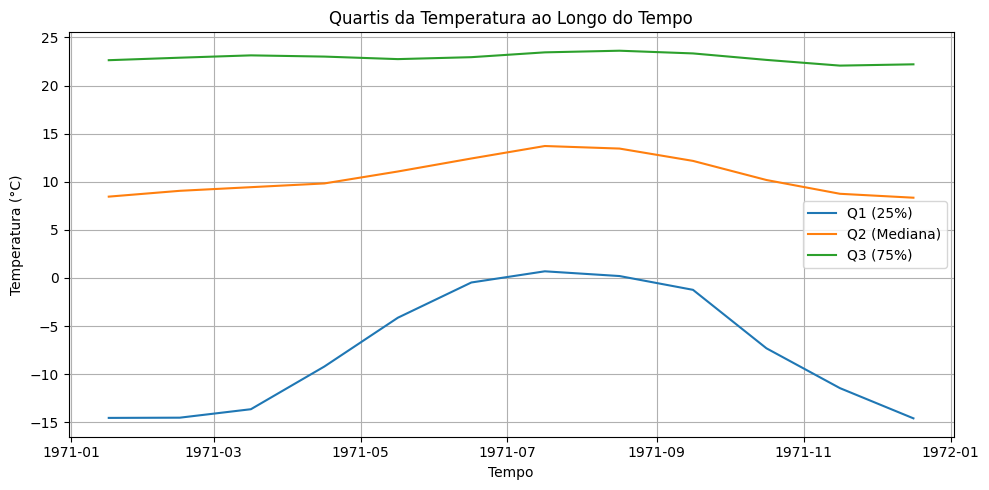

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(tas_celsius["time"], tas_quartis.sel(quantile="Q1"), label="Q1 (25%)")
plt.plot(tas_celsius["time"], tas_quartis.sel(quantile="Q2"), label="Q2 (Mediana)")
plt.plot(tas_celsius["time"], tas_quartis.sel(quantile="Q3"), label="Q3 (75%)")

plt.title("Quartis da Temperatura ao Longo do Tempo")
plt.xlabel("Tempo")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

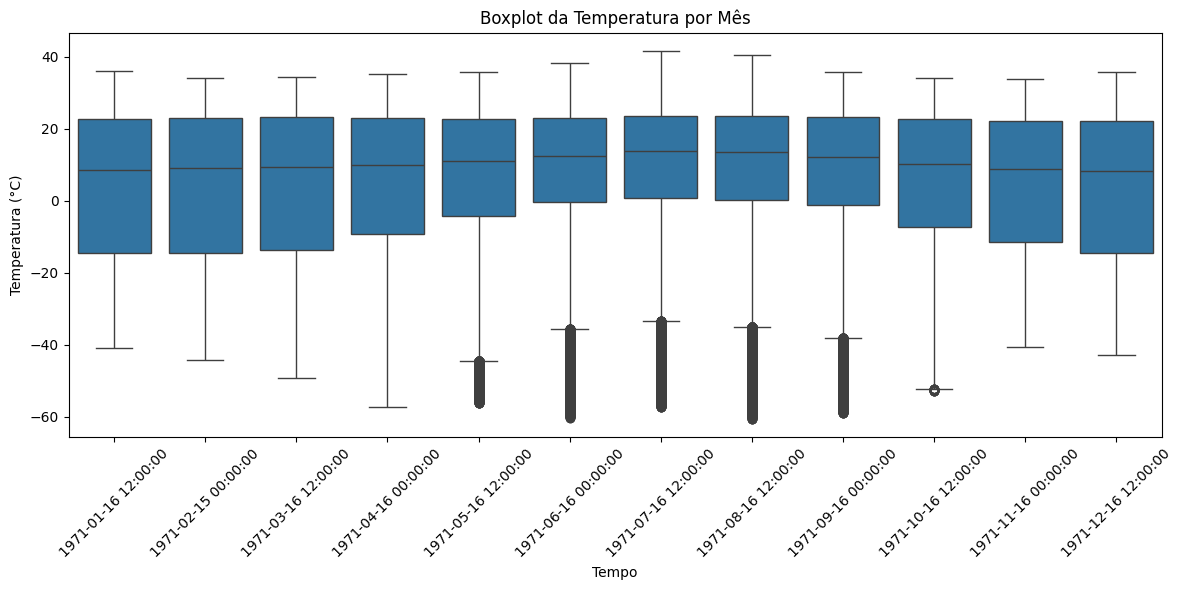

In [18]:
import seaborn as sns

tas_celsius_df = tas_celsius.to_dataframe(name="temperature").reset_index()

plt.figure(figsize=(12, 6))
sns.boxplot(data=tas_celsius_df, x="time", y="temperature")
plt.xticks(rotation=45)
plt.title("Boxplot da Temperatura por Mês")
plt.ylabel("Temperatura (°C)")
plt.xlabel("Tempo")
plt.tight_layout()
plt.show()

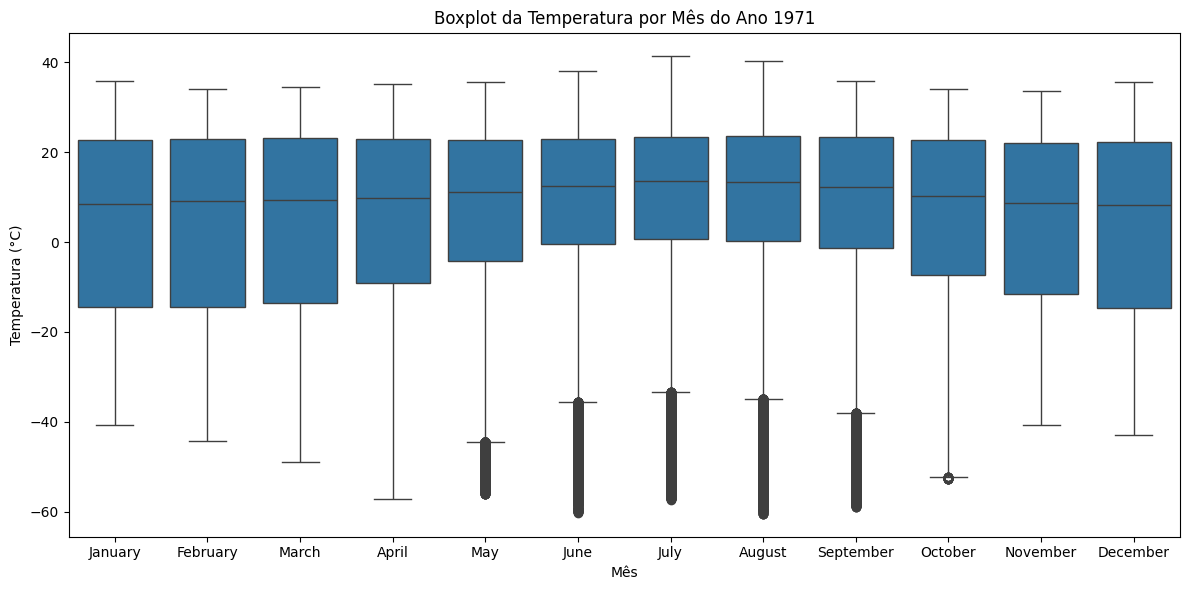

In [20]:
tas_celsius_df["month"] = tas_celsius_df["time"].dt.month_name()

plt.figure(figsize=(12, 6))
sns.boxplot(data=tas_celsius_df, x="month", y="temperature", order=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])
plt.title("Boxplot da Temperatura por Mês do Ano 1971")
plt.ylabel("Temperatura (°C)")
plt.xlabel("Mês")
plt.tight_layout()
plt.show()

In [12]:
import netCDF4
dir_tas = r"C:\Users\thais\Documents\repositorios\climate_data_processing\tas_example.nc"

try:
    ds = netCDF4.Dataset(dir_tas)
    print("Arquivo NetCDF lido com sucesso!")
except Exception as e:
    print("Erro ao abrir com netCDF4:", e)

Arquivo NetCDF lido com sucesso!


In [ ]:
# Conexão ao ESGF LLNL
conn = SearchConnection("https://esgf-node.llnl.gov/esg-search", distrib=False)

# Modelos e variáveis de interesse
modelos = ["EC-Earth3", "CanESM5", "MPI-ESM1-2-LR"]
variaveis = ["tas", "tasmin", "tasmax", "tos", "ps", "pr"]
experimentos = ["historical", "ssp245", "ssp585"]

# Dicionário para armazenar os resultados
resultados = defaultdict(lambda: defaultdict(set))

# Loop por variável e modelo
for var in variaveis:
    for modelo in modelos:
        ctx = conn.new_context(
            project="CMIP6",
            experiment_id=experimentos,
            variable_id=var,
            source_id=modelo,
            frequency="mon",
            replica=False,
            latest=True
        )
        results = list(ctx.search(ignore_facet_check=True))
        for d in results:
            experimento = d.json.get("experiment_id", [None])[0]
            if experimento:
                resultados[modelo][experimento].add(var)

# Exibição dos resultados
for modelo, exps in resultados.items():
    print(f"\nModelo: {modelo}")
    for exp, vars in exps.items():
        print(f"  Experimento: {exp} → Variáveis: {sorted(vars)}")


Modelo: EC-Earth3
  Experimento: ssp585 → Variáveis: ['pr', 'ps', 'tas', 'tasmax', 'tasmin', 'tos']

Modelo: CanESM5
  Experimento: ssp585 → Variáveis: ['pr', 'ps', 'tas', 'tasmax', 'tasmin', 'tos']

Modelo: MPI-ESM1-2-LR
  Experimento: ssp585 → Variáveis: ['pr', 'ps', 'tas', 'tasmax', 'tasmin', 'tos']
